In [ ]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model

# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
from gensim.models import Word2Vec

sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')

model = Word2Vec.load('W2V')
vocab = model.wv.vocab.keys()

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Sentence Load Complete


# FFNN Testing

In [5]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [6]:
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_ff_sets(model)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_ff_sets(model)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_ff_sets(model)

In [7]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.11% non-med: 0.89%


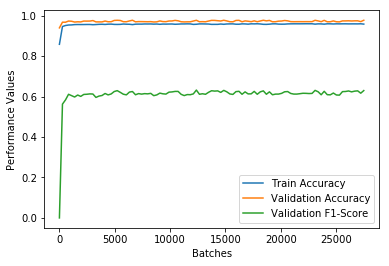

FInal Values: TrAcc: 0.958, ValAcc: 0.977, ValF1: 0.630
Test F1-Score: 0.685



In [8]:
NN = FF_Model(layers=[50])
NN.build_graph()
_,_,_,_ = NN.train(sets, epochs=5, batch=50, show_plot=True, show_progress=True)

In [9]:
res = NN.predict(sets['test_set'])
tru = np.argmax(sets['test_labels'], 1)

In [10]:
TP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 0)])
TN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 1)])
FP = len([a for a in range(len(tru)) if (res[a] == 0) and (tru[a] == 1)])
FN = len([a for a in range(len(tru)) if (res[a] == 1) and (tru[a] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
369	10448	290	49


In [11]:
proba = []
for i in range(len(res)):
    if not (sets['test_words'][i] == ')' or sets['test_words'][i] == '('):
        proba.append([sets['test_words'][i], res[i], tru[i]])

In [12]:
sk.metrics.f1_score(np.array(proba)[:,2].astype(int), np.array(proba)[:,1].astype(int), pos_label=0, average='binary')

0.77442702050663448

In [13]:
TP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 0)])
TN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 1)])
FP = len([a for a in range(len(proba)) if (proba[a][1] == 0) and (proba[a][2] == 1)])
FN = len([a for a in range(len(proba)) if (proba[a][1] == 1) and (proba[a][2] == 0)])
TFPN = [TP, TN, FP, FN]
print('TP\tTN\tFP\tFN\n{}\t{}\t{}\t{}'.format(*TFPN))

TP	TN	FP	FN
321	10448	138	49


# HyperParameter Scan

In [ ]:
emb_num = 1
NN_num = 1
emb_sizes = [30, 50, 100]
target_saturations = [0.05, 0.1, 0.3]
layers = [[30], [50], [100]]
dropouts = [0.3, 0.5, 0.8, 1.0]
learn_rates = [0.001, 0.01, 0.1]
epoch_nums = [10, 50, 100]
batch_sizes = [10, 50, 100]


model_num = emb_num * NN_num * len(emb_sizes) * len(layers) * len(dropouts) * \
            len(learn_rates) * len(epoch_nums) * len(batch_sizes) * len(target_saturations)
target = target_dict['medications']
report_percentage = 10

print(model_num)

In [ ]:
labelled_cases = Dataset.get_DS(labelled='yes')
labelled_cases.process_for_testing()

In [ ]:
iterations = [emb_sizes, target_saturations, layers, dropouts, learn_rates, epoch_nums, batch_sizes]

In [ ]:
n = 0
parameters = []
results = []
timestamp = re.sub(r':', '-', str(datetime.datetime.now()).split('.')[0])

f = open('tests/Model2/' + timestamp, 'w+')
print('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:')
f.write('EmbSz:\tSat:\tLay:\tDrop:\tLeRa:\tEpochs:\tBatSz:\tF1:\n')
for par in itertools.product(*iterations):
    best = 0
    parameters.append(par)
    for i in range(emb_num):
        model = Word2Vec(sentences, min_count=1, size=par[0])
        sets = fn.get_ff_traintest(labelled_cases, model)
        fn.saturate_training_set_labels(sets, model, target, par[1])
        for j in range(NN_num):
            n += 1
            print('Model Number: {}/{}'.format(n, model_num), end='\r')
            NN = FF_Model(input_size=par[0], layers=par[2], dropout=par[3], learn_rate=par[4])
            NN.build_graph()
            _, _, _, score = NN.train(sets, epochs=par[5], batch=par[6], report_percentage=report_percentage)
            best = max(best, score)
    results.append(best)
    print('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}'.format(*parameters[-1], results[-1]))
    f.write('{}\t{}\t{}\t{}\t{}\t{}\t{}\t{:.4f}\n'.format(*parameters[-1], results[-1]))
    
print('Max Performance: {:.4f}'.format(max(results)))  
f.write('Max Performance: {:.4f}\n'.format(max(results)))
f.close()